<a href="https://colab.research.google.com/github/ahoorarstmn/Pytorch_DL_FaraDars/blob/main/PyTorch_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Computer Vision**

**Most Common Problems in CV:**


*   **Image Classification**
*   **Object Detection**
*   **Image Segmentation**

![](https://drive.google.com/uc?id=1-KzUlCbJvWMFHtM-5XRB16TXI1pMp51W)

# **Image Classification with Convolutional Neural networks**

## **LeNet Architecture**
The LeNet architecture was first introduced by LeCun et al. in their 1998 paper, [Gradient-based Learing Applied to Document Recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)


![](https://drive.google.com/uc?id=1-Q1ZUxNIKNB2nkLqe5nARmsaNiV8BQJa)


**LeNet:**
*   2 CNN layers
*   3 Fully-Connected layers



In [ ]:
import copy
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import random_split

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt

## **Setting random seeds for reproducability**


In [ ]:
SEED = 101

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## **Retrieving CIFAR10 dataset**

In [ ]:
train_tranforms = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [ ]:
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
train_data = datasets.CIFAR10(
    root='./train_data',
    train=True,
    download=True,
    transform=train_tranforms
)

test_data = datasets.CIFAR10(
    root='./test_data',
    train=False,
    download=True,
    transform=test_transforms
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./train_data/cifar-10-python.tar.gz to ./train_data


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./test_data/cifar-10-python.tar.gz to ./test_data


## **Training and validation sets**


In [ ]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_example = len(train_data) - n_train_examples

train_data, valid_data = random_split(train_data, [n_train_examples, n_valid_example])

In [ ]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

## **Creating train, validation, and test dataloaders**


In [ ]:
BATCH_SIZE = 64

train_loader = data.DataLoader(train_data,
                               shuffle=True,
                               batch_size=BATCH_SIZE)

valid_loader = data.DataLoader(valid_data,
                               batch_size=BATCH_SIZE)

test_loader = data.DataLoader(test_data,
                              batch_size=BATCH_SIZE)

## **LeNet Implementation**


$(\frac{Height~+~2×Padding~-~Filter}{Stride}+1~,~\frac{Width~+~2×Padding~-~Filter}{Stride}+1)$

In [ ]:
class LeNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=output_dim)

    def forward(self, x):
        
        # (height + 2(padding) - filter/stride) + 1

        # Feature Extraction
        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(x)

        # Flatten
        x = x.view(-1, 16 * 5 * 5)

        # Classification
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [ ]:
OUTPUT_DIM = 10
model = LeNet(OUTPUT_DIM)

In [ ]:
from torchinfo import summary

In [ ]:
summary(model, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 28, 28]            456
├─Conv2d: 1-2                            [1, 16, 10, 10]           2,416
├─Linear: 1-3                            [1, 120]                  48,120
├─Linear: 1-4                            [1, 84]                   10,164
├─Linear: 1-5                            [1, 10]                   850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
Total mult-adds (M): 0.66
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.25
Estimated Total Size (MB): 0.31

## **Setting the optimizer and criterion**


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

## **Train on GPU**


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
model = model.to(device)
criterion = criterion.to(device)

## **Helper function to calculate accuracy**

In [ ]:
def calculate_accuracy(pred, y):
    top_pred = pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

## **Helper function to perform training epoch**


In [ ]:
def train(model, dataloader, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for features, labels in tqdm(dataloader, desc="Training Phase", leave=False):
        # Sending features and labels to device
        features = features.to(device)
        labels = labels.to(device)

        # Forward pass; making predictions and calculating loss
        pred = model(features)
        loss = criterion(pred, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # calculating accuracies
        acc = calculate_accuracy(pred, labels)
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

## **Helper function to perform evaluation epoch**


In [ ]:
def evaluate(model, dataloader, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for features, labels in tqdm(dataloader, desc="Evaluation Phase", leave=False):

            features = features.to(device)
            labels = labels.to(device)

            pred = model(features)

            loss = criterion(pred, labels)

            acc = calculate_accuracy(pred, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

## **Training on Train set**

In [ ]:
EPOCHS = 15

history = {
    'train_loss': [],
    'train_acc': [], 
    'val_loss': [],
    'val_acc': []
}

for epoch in trange(EPOCHS, desc="Epoch Number"):

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    valid_loss, valid_acc = evaluate(model, valid_loader, criterion, device)
    history['val_loss'].append(valid_loss)
    history['val_acc'].append(valid_acc)

    print(f"Epoch: [{epoch+1:02}]")
    print(f"\tTraining Loss: {train_loss:>7.3f} | Training Accuracy: {train_acc*100:>7.2f}%")
    print(f"\tValidation Loss: {valid_loss:>.3f} | Training Accuracy: {valid_acc*100:>7.2f}%")


Epoch Number:   0%|          | 0/15 [00:00<?, ?it/s]

Training Phase:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: [01]
	Training Loss:   1.693 | Training Accuracy:   37.46%
	Validation Loss: 1.473 | Training Accuracy:   45.98%


Training Phase:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: [02]
	Training Loss:   1.399 | Training Accuracy:   49.51%
	Validation Loss: 1.368 | Training Accuracy:   51.48%


Training Phase:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: [03]
	Training Loss:   1.275 | Training Accuracy:   54.40%
	Validation Loss: 1.301 | Training Accuracy:   53.38%


Training Phase:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: [04]
	Training Loss:   1.191 | Training Accuracy:   57.52%
	Validation Loss: 1.190 | Training Accuracy:   57.20%


Training Phase:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: [05]
	Training Loss:   1.124 | Training Accuracy:   59.92%
	Validation Loss: 1.159 | Training Accuracy:   58.60%


Training Phase:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: [06]
	Training Loss:   1.070 | Training Accuracy:   62.02%
	Validation Loss: 1.132 | Training Accuracy:   59.71%


Training Phase:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: [07]
	Training Loss:   1.021 | Training Accuracy:   63.76%
	Validation Loss: 1.109 | Training Accuracy:   61.14%


Training Phase:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: [08]
	Training Loss:   0.990 | Training Accuracy:   64.72%
	Validation Loss: 1.112 | Training Accuracy:   59.97%


Training Phase:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: [09]
	Training Loss:   0.946 | Training Accuracy:   66.46%
	Validation Loss: 1.091 | Training Accuracy:   61.81%


Training Phase:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: [10]
	Training Loss:   0.916 | Training Accuracy:   67.49%
	Validation Loss: 1.090 | Training Accuracy:   61.81%


Training Phase:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: [11]
	Training Loss:   0.883 | Training Accuracy:   68.82%
	Validation Loss: 1.086 | Training Accuracy:   61.79%


Training Phase:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: [12]
	Training Loss:   0.854 | Training Accuracy:   69.69%
	Validation Loss: 1.103 | Training Accuracy:   61.47%


Training Phase:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: [13]
	Training Loss:   0.827 | Training Accuracy:   70.65%
	Validation Loss: 1.110 | Training Accuracy:   61.51%


Training Phase:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: [14]
	Training Loss:   0.802 | Training Accuracy:   71.67%
	Validation Loss: 1.112 | Training Accuracy:   61.79%


Training Phase:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: [15]
	Training Loss:   0.775 | Training Accuracy:   72.35%
	Validation Loss: 1.134 | Training Accuracy:   62.12%


## **Saving Model**

In [ ]:
torch.save(model.state_dict(), 'cifar10.pt')

## **Evaluating on the Test set**


In [ ]:
model.load_state_dict(torch.load('cifar10.pt'))

test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Accuracy: {test_acc*100:.2f}%')

Evaluation Phase:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 1.146 | Test Accuracy: 62.73%


## **Plotting Confusion Matrix**

In [ ]:
def get_preds(model, dataloader, device):
    model.eval()

    images_list, labels_list, probs_list = [], [], []

    with torch.no_grad():

        for features, labels in dataloader:

            features = features.to(device)

            pred = model(features)

            prob = F.softmax(pred, dim=-1)

            images_list.append(features.cpu())
            labels_list.append(labels.cpu())
            probs_list.append(prob.cpu())

    images = torch.cat(images_list, dim=0)
    labels = torch.cat(labels_list, dim=0)
    probs = torch.cat(probs_list, dim=0)

    return images, labels, probs

In [ ]:
images, labels, probs = get_preds(model, test_loader, device)

In [ ]:
pred_labels = torch.argmax(probs, 1)

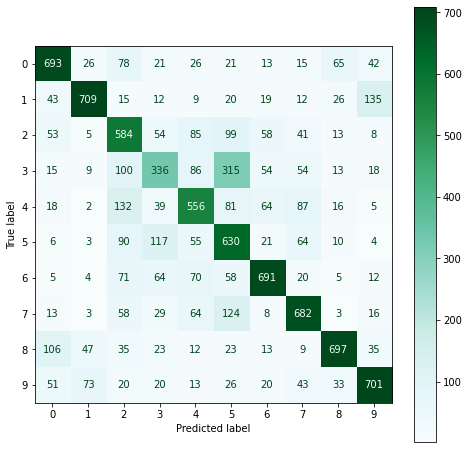

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
cm = confusion_matrix(labels, pred_labels)
cm = ConfusionMatrixDisplay(cm, display_labels=range(10))
cm.plot(values_format='d', cmap='BuGn', ax=ax);

In [ ]:
print(train_data.dataset.class_to_idx)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
